# Inference with the rnn.

We now have a model to predict the position of the mouse in v0,v1 grid cell coordinates given the firing rate of grid cells in a short time window (400 ms).

With the predicted v0,v1 we can then reconstruct the movement path in x,y coordinate system.

Here we run the model on data that the model has never seen before (test dataset).

## Test dataset

We currently use the **last random foraging trial** to do the reconstruction of random foraging path. We don't have rotation of the grid pattern from first to last random foraging condition in our selected sessions.

### Processing data segments

We want to be able to predict the path in a series of intervals. For example, all search paths of dark trials.  

We use a function that can do the prediction for either one or several intervals. When working on several intervals, we simply loop over our interval and do our prediction for this interval. 

We wanted to avoid that the end of one interval could be concatenated with the start of the next one.

### Path reconstruction in this notebook

Note that the path reconstruction shown in this notebook is not done with the best parameters. For instance, smoothing can be applied to the reconstructed grid cell position and this improves the path reconstruction.

In our analysis for the paper, we will use the prediction of the model in the v0,v1 coordinate system.

## Prediction

The model predict position in the grid cell space. We can't know where this is in xy space because the grid pattern is periodic.

But we can integrate the movement to create a path starting at 0,0. 

We use this path and compare it to the path obtained from the real x,y data that are transformed to grid space and back to movement path.

In the end, we have a real path and a predicted path.

## Measure of path reconstruction quality

### Angle between the real and predicted movement direction.

We compared the movement direction of real and predicted movement path.

We can get the angle between vector x and y using this formula:

$$
DirError = tan^{-1}(x1*y2-y1*x2,x1*x2+y1*y2)
$$

gives the angle between the vectors in a counterclockwise direction from v1 to v2. If that angle would exceed 180 degrees, then the angle is measured in the clockwise direction but given a negative value. In other words, the output of 'atan2d' always ranges from -180 to +180 degrees.

We get a distribution of angle for the reconstructed path. 

### Mean direction of angle between real and predicted movmenet direction

If the distribution is centered on 0, this means that the orientation of the grid cell representation in a condition is the same as for the data on which the rnn model was trained (first random foraging). We can estimate the orientation of the grid cell representation by getting the mean movement direction angle. 

$$
MeanDirError = tan^{-1}(\sum{sin(DirError)}, \sum{cos(DirError)} )
$$


### Stablily of the grid cell representation (and reconstruction quality)

$$
xMean = \frac{1}{n} \sum(cos(DirError))
$$
$$
yMean = \frac{1}{n} \sum(sin(DirError))
$$  
$$
DirErrorVL = \sqrt{xMean*xMean+yMean*yMean}
$$  

### 

In [74]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from scipy.stats import wilcoxon, pearsonr
from scipy.signal import find_peaks
import torch
import numpy as np
import datetime

from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
train_ifr,train_pose, train_grid_coord, test_ifr, test_pose, test_grid_coord, grid_param, train_time, test_time =  load_position_ifr_dataset() 

train_ifr.shape: (87407, 25)
train_pose.shape: (87407, 4)


In [76]:
# HYPERPARAMETERS
config = {"seq_length":20,
            "n_cells":train_ifr.shape[1],
            "hidden_size" :256,
            "num_layers" : 2,
            "num_outputs" : 4, # sin and cos of v0 and v1
            "learning_rate" : 0.01,
            "batch_size" :64,
            "num_epochs": 100}

In [77]:
train_dataset = NeuralDataset(ifr =train_ifr[:,:config["n_cells"]], pose=train_grid_coord[:,0:4], time=train_time,  seq_length=config["seq_length"])
ifr_normalization_means = train_dataset.ifr_normalization_means
ifr_normalization_stds = train_dataset.ifr_normalization_stds

test_dataset = NeuralDataset(ifr =test_ifr[:,:config["n_cells"]], 
                             pose=test_grid_coord[:,:config["num_outputs"]], 
                             time = test_time,
                             seq_length=config["seq_length"],
                             ifr_normalization_means=ifr_normalization_means,
                             ifr_normalization_stds=ifr_normalization_stds)

test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=config["batch_size"] , 
                                                       num_workers=2, shuffle=False, pin_memory=False) # to load batches

In [78]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
#print("Device available:", device)
model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)

In [79]:
fn = "../data/grid_cell_model.pt"
model.load_state_dict(torch.load(fn))

<All keys matched successfully>

In [80]:
len(test_dataset)
predictions = np.empty((len(test_dataset),4))
loadedLabels = np.empty((len(test_dataset),4))
timeHolder = np.empty((len(test_dataset),1))
predictions.shape, loadedLabels.shape

((87729, 4), (87729, 4))

In [81]:
i = 0
poseHolder = []
model.eval()
with torch.no_grad():
    for imgs, labels, time in test_data_loader: # mini-batches with data loader, imgs is sequences of brain activity, labels is position of mouse
        imgs = imgs.to(device=device) # batch x chan x 28 x 28 to batch x 28 x 28
        outputs = model(imgs)
        outputs = outputs.to(device)
        loadedLabels[i:(i+labels.shape[0]),:] = labels
        predictions[i:(i+labels.shape[0]),:] = outputs.cpu().numpy()
        timeHolder[i:(i+labels.shape[0]),:] = time

        i=i+labels.shape[0]

In [82]:
predictions.shape, loadedLabels.shape , timeHolder.shape

((87729, 4), (87729, 4), (87729, 1))

In [83]:
from scipy.ndimage import gaussian_filter1d
# Smooth the model predictions
predictions = gaussian_filter1d(predictions,sigma = 5,mode="nearest" ,axis=0)
loadedLabels = gaussian_filter1d(loadedLabels,sigma = 5,mode="nearest" ,axis=0)

In [84]:
predMvt = gridSpaceToMovementPath(predictions,grid_period=grid_param["period"],orientation=grid_param["orientation"])
mvt = gridSpaceToMovementPath(loadedLabels,grid_period=grid_param["period"],orientation=grid_param["orientation"])

In [85]:
positionSamplingRate=1/50

speed = np.sqrt(np.sum(mvt**2,axis=1))/positionSamplingRate

In [86]:
resultDf = pd.DataFrame({
    'x': mvt[:, 0],
    'y': mvt[:, 1],
    'px': predMvt[:, 0],
    'py': predMvt[:, 1],
    'speed': speed
})

In [90]:
def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.mean(np.cos(mvtDirError))
    yMean = np.mean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)


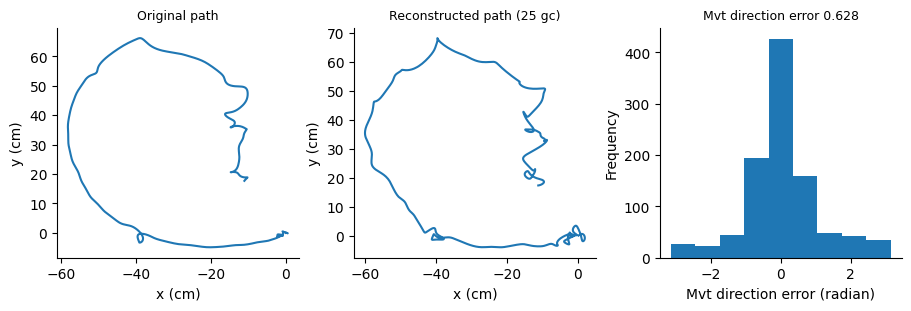

In [92]:
rowSize,colSize= 3,3
ncols=3
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
start=5000
end=6000 # 1000 samples is 10 seconds

ax = fig.add_subplot(mainSpec[0])
ax.plot(np.cumsum(mvt[start:end,0]),np.cumsum(mvt[start:end,1]))
ax.set_title("Original path",fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

ax = fig.add_subplot(mainSpec[1])
ax.plot(np.cumsum(predMvt[start:end,0]),np.cumsum(predMvt[start:end,1]))
ax.set_title("Reconstructed path ({} gc)".format(config["n_cells"]),fontsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")


mvtDir = np.arctan2(mvt[start:end,1],mvt[start:end,0])
predMvtDir = np.arctan2(predMvt[start:end,1],predMvt[start:end,0])
mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))

ax = fig.add_subplot(mainSpec[2])
ax.hist(mvtDirError,bins=np.linspace(-np.pi,np.pi,10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Mvt direction error (radian)")
ax.set_ylabel("Frequency")
ax.set_title(f"Mvt direction error {np.round(vl_mvt_direction_error(mvtDirError),3)}",fontsize=9)

fig.savefig('../img/notebook5_original_vs_decoded.png',dpi=300,bbox_inches='tight')